In [1]:
!wget https://github.com/kendallfronabarger/COAI-FISH/raw/main/fish.zip

--2023-03-24 18:23:44--  https://github.com/kendallfronabarger/COAI-FISH/raw/main/fish.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kendallfronabarger/COAI-FISH/main/fish.zip [following]
--2023-03-24 18:23:44--  https://raw.githubusercontent.com/kendallfronabarger/COAI-FISH/main/fish.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7533575 (7.2M) [application/zip]
Saving to: ‘fish.zip.1’

fish.zip.1          100%[===================>]   7.18M  --.-KB/s    in 0.03s   

2023-03-24 18:23:45 (227 MB/s) - ‘fish.zip.1’ saved [7533575/7533575]



In [ ]:
!unzip fish.zip  

This is using tensorlite, and this is importing the trout zipfile from github into here so we can train the model and use tensorlite essentially so its smaller and easier to implement. 

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [13]:
img_height, img_width = 32, 32
batch_size = 20

train_ds = tf.keras.utils.image_dataset_from_directory(
    "fish/train",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "fish/validation",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "fish/test",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 282 files belonging to 5 classes.
Found 282 files belonging to 5 classes.
Found 282 files belonging to 5 classes.


This is creating the 5 classes, which are the five species of trout, which are our label names.

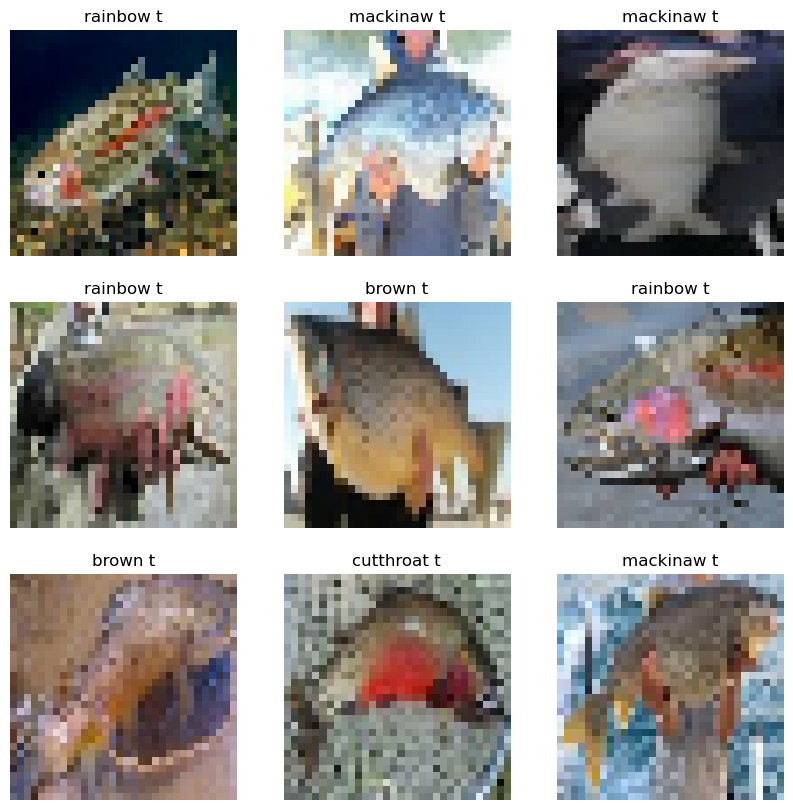

In [14]:
class_names = ["brook t", "brown t", "cutthroat t", "mackinaw t", "rainbow t"]
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

And this is making sure the trout can be projected as images here. Below is training the tensor model for image classification but making sure it can handle the smaller dimensions and fitting these image dimensions.

In [15]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation="relu"),
     tf.keras.layers.Dense(5)
    ]
)


In [16]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=['accuracy']
)

Once again we want to train it for accuracy, though this time 25 epochs were used for fitting the training data.

In [17]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 25
)

Epoch 1/25
15/15 [==============================] - 1s 30ms/step - loss: 1.6169 - accuracy: 0.2092 - val_loss: 1.5924 - val_accuracy: 0.2376
Epoch 2/25
15/15 [==============================] - 0s 23ms/step - loss: 1.5910 - accuracy: 0.2340 - val_loss: 1.5764 - val_accuracy: 0.2340
Epoch 3/25
15/15 [==============================] - 0s 23ms/step - loss: 1.5739 - accuracy: 0.2518 - val_loss: 1.5318 - val_accuracy: 0.3546
Epoch 4/25
15/15 [==============================] - 0s 25ms/step - loss: 1.5084 - accuracy: 0.3121 - val_loss: 1.4267 - val_accuracy: 0.4362
Epoch 5/25
15/15 [==============================] - 0s 21ms/step - loss: 1.4477 - accuracy: 0.3688 - val_loss: 1.3646 - val_accuracy: 0.5177
Epoch 6/25
15/15 [==============================] - 0s 23ms/step - loss: 1.3981 - accuracy: 0.3936 - val_loss: 1.3152 - val_accuracy: 0.4716
Epoch 7/25
15/15 [==============================] - 0s 18ms/step - loss: 1.3329 - accuracy: 0.4716 - val_loss: 1.2686 - val_accuracy: 0.4858
Epoch 8/25
15

In [18]:
model.evaluate(test_ds)

15/15 [==============================] - 0s 5ms/step - loss: 0.5265 - accuracy: 0.8156


[0.5265212655067444, 0.8156028389930725]

and now we evaliate the model's accurary on testing data

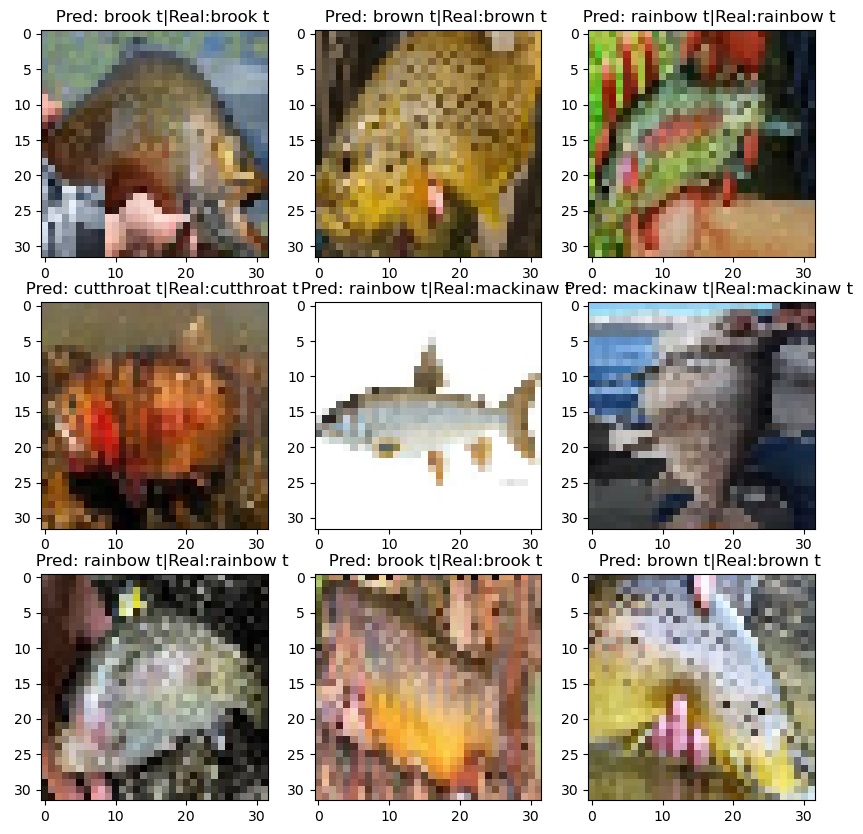

In [19]:
import numpy

plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  classifications = model(images)
  # print(classifications)
  
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = numpy.argmax(classifications[i])
    plt.title("   Pred: " + class_names[index] + "|Real:" + class_names[labels[i]])

Here we have the trout predictions with the names being present based on the predicted image and actual fish.

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpf3gw8gnm/assets


INFO:tensorflow:Assets written to: /tmp/tmpf3gw8gnm/assets
2023-03-24 18:26:35.776519: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-03-24 18:26:35.776566: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-03-24 18:26:35.777444: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpf3gw8gnm
2023-03-24 18:26:35.779650: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-03-24 18:26:35.779695: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpf3gw8gnm
2023-03-24 18:26:35.788036: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-24 18:26:35.789819: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-03-24 18:26:35.850100: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

Finally, the model was converted to a tensorlite model so it can be implimented in an application.

In [1]:
Let me know if you have any questions on this code as well.

SyntaxError: expected 'else' after 'if' expression (2293774691.py, line 1)